In [28]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

from micro_price_trading import Preprocess, TwoAssetSimulation
from micro_price_trading.config import TWENTY_SECOND_DAY

In [3]:
raw = Preprocess('Test_TBT_TBF_data.csv')
data = raw.process()

In [6]:
sim = TwoAssetSimulation(data, steps=TWENTY_SECOND_DAY)

In [19]:
paths = [-1]
prices = list()
for idx in range(0, TWENTY_SECOND_DAY, 15):
    paths.append(paths[-1]+2)
    prices.append(sim.states.mid_1[idx])
    

In [20]:
np.mean(prices)

18.236410256410238

In [15]:
paths = [-1]
prices = list()
for idx in range(0, TWENTY_SECOND_DAY, 15):
    paths.append(paths[-1]+1)
    prices.append(sim.states.mid_2[idx])
    

In [16]:
np.mean(prices)

16.704743589743586

In [60]:
def base_twap(t, asset, iters):
    shares = 1 if asset == 2 else 2
    shares1 = list()
    shares2 = list()
    prices = list()
    for _ in trange(iters):
        shares1.append([0])
        shares2.append([0])
        prices.append([])
        for idx in range(0, TWENTY_SECOND_DAY, t):
            if asset == 1:
                shares1[-1].append(shares1[-1][-1]+shares)
                shares2[-1].append(0)
            else:
                shares2[-1].append(shares2[-1][-1]+shares)
                shares1[-1].append(0)
            prices[-1].append(sim.states[f'mid_{asset}'][idx])
        sim._reset_simulation()
    return np.array(prices), pd.DataFrame({'asset1': shares1[-1], 'asset2': shares2[-1]})

In [135]:
def random_twap(t, iters, weights=(0.5, 0.5)):
    shares1 = list()
    shares2 = list()
    buy1 = list()
    buy2 = list()
    prices1 = list()
    prices2 = list()
    for _ in trange(iters):
        shares1.append([0])
        shares2.append([0])
        prices1.append([])
        prices2.append([])
        buy1.append([])
        buy2.append([])
        for idx in range(0, TWENTY_SECOND_DAY, t):
            asset = np.random.choice([1, 2], p=weights)
            shares = 1 if asset == 2 else 2
            if asset == 1:
                shares1[-1].append(shares1[-1][-1]+shares)
                shares2[-1].append(shares2[-1][-1])
                prices1[-1].append(sim.states[f'mid_{asset}'][idx])
                buy1[-1].append(shares)
            else:
                shares2[-1].append(shares2[-1][-1]+shares)
                shares1[-1].append(shares1[-1][-1])
                prices2[-1].append(sim.states[f'mid_{asset}'][idx])
                buy2[-1].append(shares)
        sim._reset_simulation()
    return prices1, prices2, buy1, buy2, np.array(shares1), np.array(shares2)

In [110]:
prices1, shares1 = base_twap(15, 1, 10)

In [111]:
prices2, shares2 = base_twap(15, 2, 10)

In [151]:
p1, p2, b1, b2, s1, s2 = random_twap(15, 10, (0.05, 0.95))

In [152]:
p1_means = [np.mean(l) for l in p1]
p2_means = [np.mean(l) for l in p2]

In [153]:
avg1 = (p1_means-prices1.mean(axis=1))*s1[:, -1]

In [154]:
avg2 = (p2_means-prices2.mean(axis=1))*s2[:, -1]

In [155]:
(avg1 + avg2).mean()

-1.2026025641025195

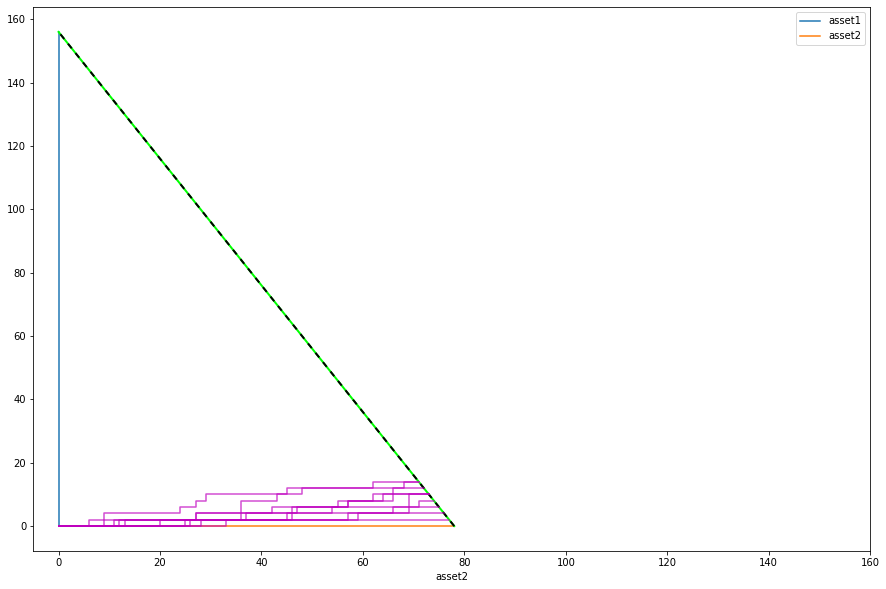

In [156]:
fig, ax = plt.subplots(figsize=(15, 10))
shares1.plot('asset2', 'asset1', kind='line', ax=ax, label='asset1')
shares2.plot('asset2', 'asset1', kind='line', ax=ax, label='asset2')
ax.plot([shares2.asset2.iloc[-1], 0], [0, shares1.asset1.iloc[-1]], 'lime', linewidth=2)
ax.plot([shares2.asset2.iloc[-1], 0], [0, shares1.asset1.iloc[-1]], 'k--', linewidth=2, dashes=(3, 3))
ax.set_xlim(-5, 160)
for idx in range(s1.shape[0]):
    ax.plot(s2[idx], s1[idx], 'm', alpha=0.7)